In [2]:
import geopandas as gpd
import pandas as pd
import s3fs
import numpy as np
import math
from shapely.geometry import Polygon, box
from sklearn.neighbors import KernelDensity
#import plotly.express as px
import matplotlib.pyplot as plt

# 1. Read Observation Data into Geopandas Frame

In [3]:
DATASET_PATH = '../data/full_dataset.csv'
RASTER_PATH = '../data/rasters/'

In [4]:

BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/observations'
train_file, test_file = 'observations_us_train.csv', 'observations_us_test.csv'
s3_train_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, train_file)

In [5]:
train_usa = pd.read_csv(s3_train_path,header='infer', sep=';',)
train_usa.head()

,observation_id,latitude,longitude,species_id,subset
0,20000173,33.197660,-116.180680,4911,train
1,20000175,34.037968,-118.876755,4912,train
2,20000176,27.620740,-97.222690,4913,train
3,20000177,29.155582,-95.653930,4914,train
4,20000179,36.605740,-121.959510,4915,train


In [6]:
train_df, val_df = train_usa[train_usa.subset == 'train'], train_usa[train_usa.subset == 'val']
len(train_df), len(val_df)

(931132, 25099)

In [7]:
del train_usa

In [8]:
train_gdf = gpd.GeoDataFrame(train_df, geometry=gpd.points_from_xy(train_df.longitude, train_df.latitude))\
                .drop(['latitude', 'longitude'], axis=1).set_crs(4326)
# train_gdf.to_crs
train_gdf.head()

,observation_id,species_id,subset,geometry
0,20000173,4911,train,POINT (-116.18068 33.19766)
1,20000175,4912,train,POINT (-118.87676 34.03797)
2,20000176,4913,train,POINT (-97.22269 27.62074)
3,20000177,4914,train,POINT (-95.65393 29.15558)
4,20000179,4915,train,POINT (-121.95951 36.60574)


In [9]:
train_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 2. Create grid for USA (AOI)

## 2.1 Use a generic map outline for the USA

In [10]:
import geopandas as gpd
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

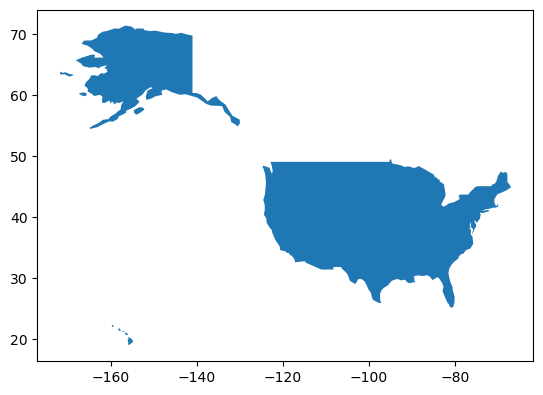

In [11]:
usa = world[world['name'] == 'United States of America']
usa.plot()

## 2.1 Now we only want continental USA, so clip to continental bounds

<AxesSubplot:>

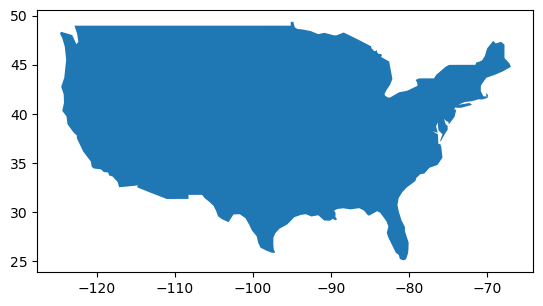

In [12]:
from shapely.geometry import Polygon

continental_bounds = Polygon([(-130,50), (-60,50), (-60,20), (-130,20)])
usa = usa.clip(continental_bounds)
usa.plot()

# 3. Species Level Kernel Function

## 3.1 Extract one species to test with

In [ ]:
species_id_counts = train_df.species_id.value_counts()
species_id_counts.min()

In [ ]:
plt.hist(species_id_counts, bins=50)
plt.show()

## Build a class with all the data and functions needed for gridding and kernels

In [13]:
%load_ext autoreload

In [48]:
#Run this to reload the python file
%autoreload 2
from grid import Observations

In [49]:
obs_usa = Observations(train_gdf, usa, grid_res_deg=0.5)

Gridding..
Creating Land Mask..
Num entries before masking:  6018
Num entries after masking:  3598
(3598, 2)


In [50]:
obs_usa.grid_gd

,geometry,grid_id
0,"POLYGON ((-124.68721 48.08000, -124.68721 48.5...",0
1,"POLYGON ((-124.18721 39.58000, -124.18721 40.0...",1
2,"POLYGON ((-124.18721 40.08000, -124.18721 40.5...",2
3,"POLYGON ((-124.18721 40.58000, -124.18721 41.0...",3
4,"POLYGON ((-124.18721 41.08000, -124.18721 41.5...",4
...,...,...
3593,"POLYGON ((-67.18721 45.58000, -67.18721 46.080...",3593
3594,"POLYGON ((-67.18721 46.08000, -67.18721 46.580...",3594
3595,"POLYGON ((-67.18721 46.58000, -67.18721 47.080...",3595
3596,"POLYGON ((-66.68721 44.58000, -66.68721 45.080...",3596


### Optimized grid testing

In [122]:
unique, counts = np.unique(obs_usa.land_mask, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

[[    0 59733]
 [    1 82947]]


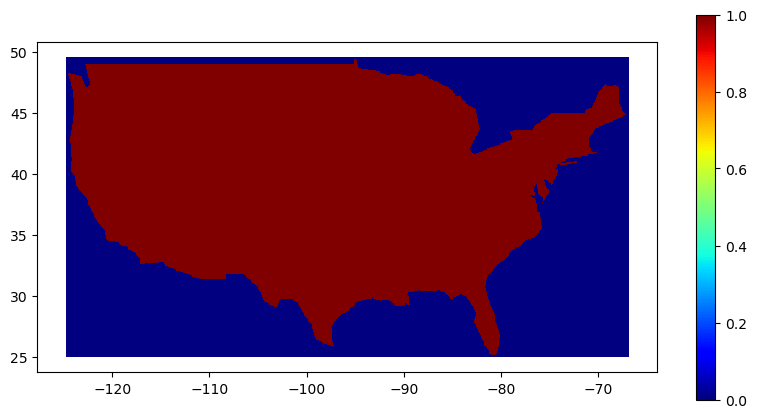

In [117]:
fig, ax = plt.subplots(figsize=(10,10))
obs_usa.grid_gd.plot(ax=ax, column='mask', edgecolor = 'none', legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
# usa.plot(ax=ax,  color='none')
# train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

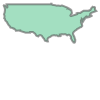

In [109]:
w = usa.simplify(0.1).geometry
w.iloc[0]

In [118]:
series = obs_usa.grid_gd.within(w.iloc[0]).to_numpy()

unique, counts = np.unique(series, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

[[    0 59733]
 [    1 82947]]


In [16]:
obs_usa.grid_gd.loc[5510:5520].geometry.centroid

/tmp/ipykernel_4404/2153824327.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  obs_usa.grid_gd.loc[5510:5520].geometry.centroid


5510    POINT (-122.53721 34.83000)
5511    POINT (-122.53721 34.93000)
5512    POINT (-122.53721 35.03000)
5513    POINT (-122.53721 35.13000)
5514    POINT (-122.53721 35.23000)
5515    POINT (-122.53721 35.33000)
5516    POINT (-122.53721 35.43000)
5517    POINT (-122.53721 35.53000)
5518    POINT (-122.53721 35.63000)
5519    POINT (-122.53721 35.73000)
5520    POINT (-122.53721 35.83000)
dtype: geometry

In [123]:
obs_usa.grid_np[5510:5521]

array([[-119.53721008,   48.63      ],
       [-119.53721008,   48.73      ],
       [-119.53721008,   48.83      ],
       [-119.53721008,   48.93      ],
       [-119.43721008,   34.43      ],
       [-119.43721008,   34.53      ],
       [-119.43721008,   34.63      ],
       [-119.43721008,   34.73      ],
       [-119.43721008,   34.83      ],
       [-119.43721008,   34.93      ],
       [-119.43721008,   35.03      ]])

### Combine chosen_species_grid into the primary observations grid with the following structures:

**Possibility A: Per observation**

| SpeciesID | Probability | GridID | Geometry |
| --- | --- | --- | --- |
| 115 | 0.7 | 7743 | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |


Or

**Possibility B: Per Grid**

| SpeciesID | SpeciesID | ... | SpeciesID | GridID | Geometry |
| --- | --- | --- | --- | --- | --- |
| 115 | 4443 | ... | 19328 | 52  | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |

We pick option A, since it provides a more memory efficient method

### TEST Displays
Let's take species ID: 115, that has 723 observations across the USA

In [51]:
chosen_id = 115
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.0, kernel='gaussian', cumulative=True)

In [52]:
obs_usa.grid_kde

,geometry,grid_id,prob_115
0,"POLYGON ((-124.68721 48.08000, -124.68721 48.5...",0,0.000000
1,"POLYGON ((-124.18721 39.58000, -124.18721 40.0...",1,0.000000
2,"POLYGON ((-124.18721 40.08000, -124.18721 40.5...",2,0.000000
3,"POLYGON ((-124.18721 40.58000, -124.18721 41.0...",3,0.000000
4,"POLYGON ((-124.18721 41.08000, -124.18721 41.5...",4,0.000000
...,...,...,...
3593,"POLYGON ((-67.18721 45.58000, -67.18721 46.080...",3593,0.000000
3594,"POLYGON ((-67.18721 46.08000, -67.18721 46.580...",3594,0.000000
3595,"POLYGON ((-67.18721 46.58000, -67.18721 47.080...",3595,0.000000
3596,"POLYGON ((-66.68721 44.58000, -66.68721 45.080...",3596,0.000033


In [55]:
kernels = obs_usa.grid_kde

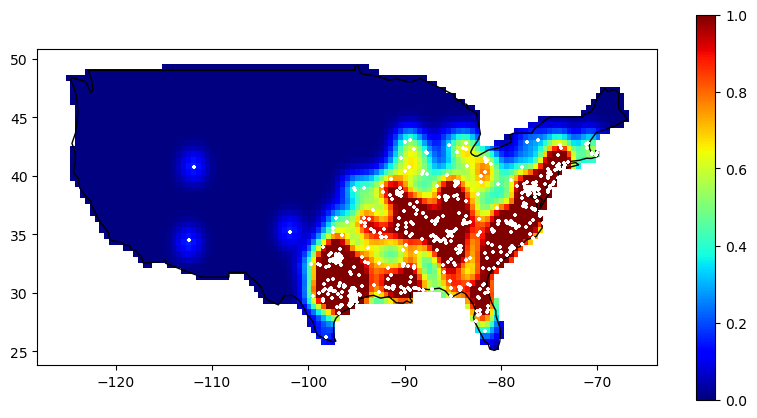

In [56]:
col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

#### Let's do a few more and make it cumulative

In [21]:
chosen_id = 4911
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.3, kernel='epanechnikov', cumulative=True)


In [22]:
chosen_id = 46
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=2.0, kernel='linear', cumulative=True)

In [23]:
obs_usa.grid_kde

,geometry,grid_id,prob_115,prob_4911,prob_46
0,"POLYGON ((-124.68721 24.98000, -124.68721 25.0...",0,0.0,0.0,0.0
1,"POLYGON ((-124.68721 25.08000, -124.68721 25.1...",1,0.0,0.0,0.0
2,"POLYGON ((-124.68721 25.18000, -124.68721 25.2...",2,0.0,0.0,0.0
3,"POLYGON ((-124.68721 25.28000, -124.68721 25.3...",3,0.0,0.0,0.0
4,"POLYGON ((-124.68721 25.38000, -124.68721 25.4...",4,0.0,0.0,0.0
...,...,...,...,...,...
142675,"POLYGON ((-66.78721 49.08000, -66.78721 49.180...",142675,0.0,0.0,0.0
142676,"POLYGON ((-66.78721 49.18000, -66.78721 49.280...",142676,0.0,0.0,0.0
142677,"POLYGON ((-66.78721 49.28000, -66.78721 49.380...",142677,0.0,0.0,0.0
142678,"POLYGON ((-66.78721 49.38000, -66.78721 49.480...",142678,0.0,0.0,0.0


In [ ]:
kernels = obs_usa.grid_kde.clip(usa).reset_index(drop=True)

col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
ax.set_title('Probability Field of Species {}'.format(chosen_id))
plt.show()

In [ ]:
obs_usa.clear_kde()

## Grid and KDE all species

In [41]:
import warnings
warnings.filterwarnings('ignore')

obs_usa.kde(radius=1.0)

100%|██████████| 14124/14124 [05:18<00:00, 44.39it/s]


In [18]:
obs_usa.grid_kde.columns

Index(['geometry', 'grid_id', 'mask', 'prob_4911', 'prob_4912', 'prob_4913',
       'prob_4914', 'prob_4915', 'prob_4916', 'prob_2950',
       ...
       'prob_2309', 'prob_2897', 'prob_1460', 'prob_3932', 'prob_1436',
       'prob_1948', 'prob_4678', 'prob_1232', 'prob_2985', 'prob_272'],
      dtype='object', length=14127)

In [42]:
obs_usa.save_kde('geolifeclef_usa_0.5deg_kde')

In [45]:
obs_usa.clear_kde()
obs_usa.load_kde('geolifeclef_usa_0.5deg_kde.feather')

In [46]:
obs_usa.grid_kde

,geometry,grid_id,prob_4911,prob_4912,prob_4914,prob_4915,prob_4916,prob_2950,prob_4917,prob_4918,...,prob_1647,prob_17036,prob_16086,prob_371,prob_2309,prob_2897,prob_1460,prob_1436,prob_1948,prob_2985
0,"POLYGON ((-123.68721 40.08000, -123.68721 40.5...",0,0.0,0.140454,0.0,0.236986,0.0,0.292686,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((-123.68721 40.58000, -123.68721 41.0...",1,0.0,0.159155,0.0,0.299609,0.0,0.353801,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"POLYGON ((-123.68721 41.08000, -123.68721 41.5...",2,0.0,0.140454,0.0,0.299609,0.0,0.372506,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000020,0.0,0.0,0.0,0.0,0.0
3,"POLYGON ((-123.68721 41.58000, -123.68721 42.0...",3,0.0,0.096532,0.0,0.236986,0.0,0.341149,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0
4,"POLYGON ((-123.68721 46.58000, -123.68721 47.0...",4,0.0,0.000000,0.0,0.000000,0.0,0.262126,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3191,"POLYGON ((-68.18721 46.58000, -68.18721 47.080...",3191,0.0,0.000000,0.0,0.000000,0.0,0.060930,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3192,"POLYGON ((-67.68721 44.58000, -67.68721 45.080...",3192,0.0,0.000000,0.0,0.000000,0.0,0.230591,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3193,"POLYGON ((-67.68721 45.08000, -67.68721 45.580...",3193,0.0,0.000000,0.0,0.000000,0.0,0.195186,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3194,"POLYGON ((-67.68721 45.58000, -67.68721 46.080...",3194,0.0,0.000000,0.0,0.000000,0.0,0.134383,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


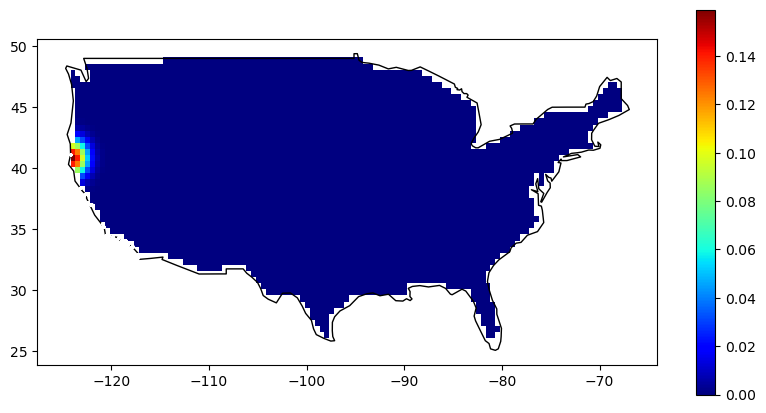

In [47]:
chosen_id = 4912
col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
obs_usa.grid_kde.plot(ax=ax, column=col_name, edgecolor = 'none', legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

## Dask implementation

In [12]:
%load_ext autoreload

In [17]:

%autoreload 2
from grid_dask import *

[autoreload of grid_dask failed: Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/srv/conda/envs/notebook/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/jovyan/sdm-geolifeCLEF/preprocessing/grid_dask.py", line 64, in <module>
    class Observations:
  File "/home/jovyan/sdm-geolifeCLEF/preprocessing/grid_dask.py", line 270, in Observations
    @dask.delayed
NameError: name 'dask' is not defined
]


In [ ]:
# setup_dask_cluster()
# import dask_gateway

# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# cluster.adapt(minimum=2, maximum=50)
# print(cluster.dashboard_link)

In [32]:
# shutdown_all_clusters()
setup_dask_cluster()
# client.close()

<Client: 'tls://10.244.225.54:8786' processes=0 threads=0, memory=0 B>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.0e1f5feb8c654e8fba536d67986f766f/status


In [14]:
obs_usa = Observations(train_gdf, total_bounds=usa.total_bounds, grid_res_deg=0.1)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.6d315d1f4a744bae81d0ec6fcf2bac01/status <Client: 'tls://10.244.159.87:8786' processes=0 threads=0, memory=0 B>
580 246 (142680, 2)


In [15]:
obs_usa.grid_gd

,geometry,grid_id
0,"POLYGON ((-124.68721 24.98000, -124.68721 25.0...",0
1,"POLYGON ((-124.68721 25.08000, -124.68721 25.1...",1
2,"POLYGON ((-124.68721 25.18000, -124.68721 25.2...",2
3,"POLYGON ((-124.68721 25.28000, -124.68721 25.3...",3
4,"POLYGON ((-124.68721 25.38000, -124.68721 25.4...",4
...,...,...
142675,"POLYGON ((-66.78721 49.08000, -66.78721 49.180...",142675
142676,"POLYGON ((-66.78721 49.18000, -66.78721 49.280...",142676
142677,"POLYGON ((-66.78721 49.28000, -66.78721 49.380...",142677
142678,"POLYGON ((-66.78721 49.38000, -66.78721 49.480...",142678


In [16]:
obs_usa.kde(radius=1.0)

  0%|          | 0/14124 [00:00<?, ?it/s]


TypeError: 'Client' object is not callable

In [44]:
obs_usa.close_dask_client()

2022-11-22 05:06:03,480 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [29]:
obs_usa.grid_kde

,geometry,grid_id
0,"POLYGON ((-124.68721 24.98000, -124.68721 25.0...",0
1,"POLYGON ((-124.68721 25.08000, -124.68721 25.1...",1
2,"POLYGON ((-124.68721 25.18000, -124.68721 25.2...",2
3,"POLYGON ((-124.68721 25.28000, -124.68721 25.3...",3
4,"POLYGON ((-124.68721 25.38000, -124.68721 25.4...",4
...,...,...
142675,"POLYGON ((-66.78721 49.08000, -66.78721 49.180...",142675
142676,"POLYGON ((-66.78721 49.18000, -66.78721 49.280...",142676
142677,"POLYGON ((-66.78721 49.28000, -66.78721 49.380...",142677
142678,"POLYGON ((-66.78721 49.38000, -66.78721 49.480...",142678
